---
## Step 0: Load The Data

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

In [10]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1]

n_classes = 10

In [13]:
CATEGORIES = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck']

<Figure size 432x288 with 0 Axes>

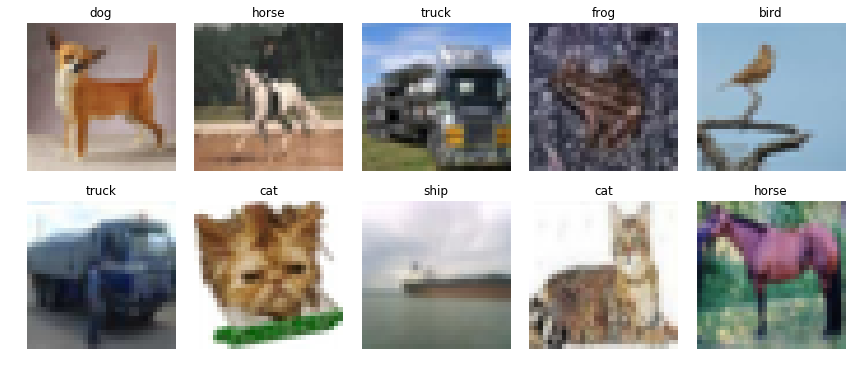

In [14]:
# Data exploration visualization code goes here.
# Feel free to use as many code cells as needed.
def plot_images(images, titles, columns, image_height, cmap=plt.jet()):
    rows = (len(images) + columns - 1) // columns
    fig_height = rows * image_height
    fig, axs = plt.subplots(rows, columns, figsize=(15, fig_height))
    fig.subplots_adjust(hspace=0.2, wspace=0.001)
    axs = axs.ravel()
    for idx, image in enumerate(images):
        axs[idx].axis('off')
        axs[idx].imshow(image, cmap)
        axs[idx].set_title(titles[idx])

# show image of 10 random data points
def plot_samples(x_data, y_data, count, columns, image_height, cmap=plt.jet()):
    titles = []
    images = []
    for _ in range(count):
        idx = random.randint(0, len(x_data))
        image = x_data[idx]
        images.append(image)
        titles.append(CATEGORIES[y_data[idx]])
    
    plot_images(images, titles, columns, image_height, cmap)

# Randomly plot 10 signs from training data
plot_samples(X_train, y_train, count=10, columns=5, image_height=3)

In [15]:
# Normalize
def normalize(x_data):
    return (x_data - 128.0) / 128.0

X_train_norm = normalize(X_train)
X_valid_norm = normalize(X_valid)
X_test_norm = normalize(X_test)

### Model Architecture

In [16]:
# Define your architecture here.
# Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib.layers import flatten
tf.reset_default_graph()

# RGB LeNet
# NOTE: use dropout in network
def LeNet(x, keep_prob):
    mu = 0
    sigma = 0.1

    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    fc0 = flatten(conv2)
    
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    fc3_W = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean=mu, stddev=sigma))
    fc3_b = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return (logits, conv1, conv2, fc1, fc2)

x = tf.placeholder(tf.float32, (None, image_shape, image_shape, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [17]:
# Train your model here.
# Calculate and report the accuracy on the training and validation set.
# Once a final model architecture is selected
logits, conv1, conv2, fc1, fc2 = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)

# Add the optimizer
rate = 0.0009
optimizer = tf.train.AdamOptimizer(
    learning_rate=rate,
    # Exponential decay in AdamOptimizer
    beta1=0.9,
    beta2=0.999,)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

EPOCHS = 40
BATCH_SIZE = 128

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y:batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [ ]:
# Training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_norm)
    
    print("Training...")
    for i in range(EPOCHS):
        X_shuffle, y_shuffle = shuffle(X_train_norm, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            X_batch, y_batch = X_shuffle[offset:end], y_shuffle[offset:end]
            sess.run(training_operation, feed_dict={x: X_batch, y: y_batch, keep_prob: 0.5})
        validation_accuracy = evaluate(X_valid_norm, y_valid)
        print("Epoch {} ".format(i+1))
        print("Validation accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print('Model saved')

Training...
Epoch 1 
Validation accuracy = 0.383

Epoch 2 
Validation accuracy = 0.448

Epoch 3 
Validation accuracy = 0.474

Epoch 4 
Validation accuracy = 0.501

Epoch 5 
Validation accuracy = 0.514

Epoch 6 
Validation accuracy = 0.531

Epoch 7 
Validation accuracy = 0.539

Epoch 8 
Validation accuracy = 0.549

Epoch 9 
Validation accuracy = 0.553

Epoch 10 
Validation accuracy = 0.554

Epoch 11 
Validation accuracy = 0.568

Epoch 12 
Validation accuracy = 0.566

Epoch 13 
Validation accuracy = 0.575

Epoch 14 
Validation accuracy = 0.575

Epoch 15 
Validation accuracy = 0.582

Epoch 16 
Validation accuracy = 0.587

Epoch 17 
Validation accuracy = 0.597

Epoch 18 
Validation accuracy = 0.590

Epoch 19 
Validation accuracy = 0.595

Epoch 20 
Validation accuracy = 0.598

Epoch 21 
Validation accuracy = 0.605

Epoch 22 
Validation accuracy = 0.599

Epoch 23 
Validation accuracy = 0.606

Epoch 24 
Validation accuracy = 0.597

Epoch 25 
Validation accuracy = 0.604

Epoch 26 
Validation a